# SpectralClustering and DBSCAN with minHash

In [2]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from scipy.sparse import csr_matrix
import hashlib
from random import randint

sparsity_factor = 0.01
samples = 3000
features = 10000
classes = 2
clusters_per_class = 2
scale_ = 1.0
data_dense, y_true = make_classification(n_samples=samples, n_features=features, n_informative=2, 
                                 n_redundant=2, n_repeated=0, n_classes=classes, 
                                 n_clusters_per_class=clusters_per_class, weights=None, flip_y=0.01,
                                 class_sep=1.0, hypercube=True, shift=0.0, scale=scale_,
                                 shuffle=True, random_state=None)
instances_list = []
features_list = []
data_list = []
for i in xrange(len(data_dense)):
    for j in xrange(len(data_dense[i])):
        instances_list.append(i)
        features_list.append(hash(str(data_dense[i][j])[0:4]+str(j)) % (features/sparsity_factor))
        data_list.append(data_dense[i][j])
# print instances_list
# print features_list
# print data_list
data_sparse = csr_matrix((data_list, (instances_list, features_list)))

Automatically created module for IPython interactive environment
SpectralClustering :  -2.29101388706e-05
Size y:  0
Size X:  3000
Size X[1]:  999553
Labels:  [1 0 1 ..., 1 0 0]
MinHashSpectralClustering :  -0.000219505416367
Size y:  0
Size X:  3000
Size X[1]:  999553
DBSCAN :  0.0
Size y:  0
Size X:  3000
Size X[1]:  999553
MinHashDBSCAN :  0.0
Size y:  0
Size X:  3000
Size X[1]:  999553


/home/joachim/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


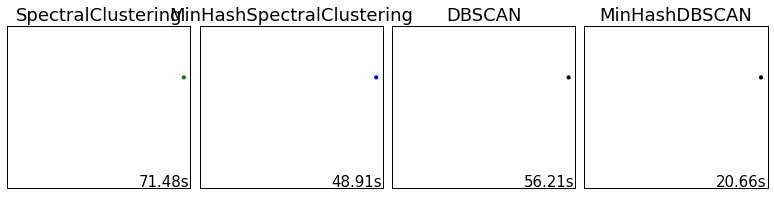

In [3]:
%matplotlib inline
print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection

from neighborsMinHash.clustering import MinHashSpectralClustering 
from neighborsMinHash.clustering import MinHashDBSCAN


np.random.seed(0)


colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'SpectralClustering', 'MinHashSpectralClustering', 'DBSCAN', 'MinHashDBSCAN']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

X = data_sparse

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create clustering estimators
spectral = cluster.SpectralClustering(n_clusters=2,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors", n_neighbors=10)
minHashSpectral = MinHashSpectralClustering(n_clusters=2,
                                      eigen_solver='arpack', n_neighbors=10)

dbscanMinHash = MinHashDBSCAN(eps=.2)
dbscan = cluster.DBSCAN(eps=.2, metric="euclidean")


clustering_algorithms=[spectral, minHashSpectral, dbscan, dbscanMinHash]
list_y = []

data_projection = SparseRandomProjection(n_components=2, random_state=1)
data_transformed = data_projection.fit_transform(X)
x = []
y = []

for datapoint in data_transformed:
    x.append(datapoint[0,0])
    y.append(datapoint[0,1])
    
result = []
for name, algorithm in zip(clustering_names, clustering_algorithms):
    t0 = time.time()
    y_pred = algorithm.fit_predict(X)
    t1 = time.time()
    y_pred = y_pred.astype(np.int)
    print name, ": ", adjusted_rand_score(y_true, y_pred)
    plt.subplot(4, len(clustering_algorithms), plot_num)
        
    plt.title(name, size=18)
    print "Size y: ", len(list_y)
    print "Size X: ", X.shape[0]
    print "Size X[1]: ", X.shape[1]
    plt.scatter(x, y, color=colors[y_pred].tolist(), s=10)

    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()
